<a href="https://colab.research.google.com/github/aslestia/ACS_2025/blob/main/ACS_Week04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Week 4 — Policy Gradient & Actor–Critic (CartPole)
Notebook ini berisi implementasi **REINFORCE** dan **Actor–Critic** pada lingkungan `CartPole-v1`.

## Isi
1. Persiapan & Instalasi
2. Utilitas umum (seed, logger, plot)
3. REINFORCE (episodic policy gradient)
4. Actor–Critic (on-policy, advantage = TD error)
5. Eksperimen & Perbandingan (learning curves)
6. Catatan diskusi & pertanyaan reflektif


In [ ]:

# === 1) Persiapan & Instalasi (jalankan sel ini sekali) ===
# Jika belum punya paket, jalankan baris pip install berikut (hapus komentar #):
# !pip -q install gymnasium pygame torch matplotlib numpy

import sys, math, time, random, os
import numpy as np
import matplotlib.pyplot as plt

# Cek dan impor gym/gymnasium
try:
    import gymnasium as gym
    GYMN = "gymnasium"
except Exception as e:
    try:
        import gym
        GYMN = "gym"
    except Exception as e2:
        raise RuntimeError("Tidak menemukan gymnasium ataupun gym. Jalankan pip install sesuai instruksi di atas.")

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

print("Using:", GYMN, "| PyTorch:", torch.__version__)


Using: gymnasium | PyTorch: 2.8.0+cu126


In [ ]:

# === 2) Utilitas umum ===
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class Meter:
    """Logger sederhana untuk menyimpan reward per episode dan moving average."""
    def __init__(self, window=20):
        self.rewards = []
        self.window = window

    def push(self, r):
        self.rewards.append(r)

    def moving_avg(self):
        if len(self.rewards) == 0:
            return []
        vals = []
        q = deque(maxlen=self.window)
        for x in self.rewards:
            q.append(x)
            vals.append(np.mean(q))
        return vals

def plot_learning_curves(curves, labels, title="Learning Curves", xlabel="Episode", ylabel="Total Reward"):
    plt.figure()
    for y, lbl in zip(curves, labels):
        plt.plot(y, label=lbl)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



## 3) REINFORCE — Policy Gradient Episodik
**Rumus update**  
\[
\theta \leftarrow \theta + \alpha \, G_t \, \nabla_\theta \log \pi_\theta(a_t|s_t)\
\]

dengan \(G_t\) = return terdiskonto dari waktu \(t\).


In [ ]:

class PolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),

            nn.Linear(hidden, act_dim)
        )

    def forward(self, x):
        logits = self.net(x)
        return torch.distributions.Categorical(logits=logits)

def compute_returns(rewards, gamma):
    """Hitung G_t (return ke depan) untuk seluruh step dalam 1 episode."""
    G = 0.0
    returns = []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)
    returns.reverse()
    return torch.tensor(returns, dtype=torch.float32)

def train_reinforce(env_name="CartPole-v1", episodes=500, gamma=0.99, lr=3e-3, seed=42, render=False):
    set_seed(seed)
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    policy = PolicyNet(obs_dim, act_dim)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    meter = Meter(window=20)

#Loop episode (trajectory collection)
    for ep in range(episodes):
        # Reset episode
        if GYMN == "gymnasium":
            obs, info = env.reset(seed=seed+ep)
        else:
            obs = env.reset(seed=seed+ep)
        log_probs, rewards = [], []
        done = False
        total_r = 0.0

        while not done:
            if render:
                env.render()
            obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            dist = policy(obs_t)    # policy πθ(a|s) sebagai Categorical(logits=...)
            action = dist.sample()   # sample a_t ~ πθ(.|s_t)  (eksplorasi)
            log_probs.append(dist.log_prob(action))

            if GYMN == "gymnasium":
                next_obs, reward, terminated, truncated, info = env.step(action.item())
                done = terminated or truncated
            else:
                next_obs, reward, done, info = env.step(action.item())  # 1 langkah

            rewards.append(reward)    # r_t (di CartPole = +1 per step)
            total_r += reward
            obs = next_obs

        #Hitung return per-step
        # Compute loss (episode-wise)
        returns = compute_returns(rewards, gamma)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # normalisasi, semacam baseline sederhana (mengurangi varians)

        #Update parameter policy (setelah episode selesai)
        loss = 0.0
        for logp, Gt in zip(log_probs, returns):
            loss -= logp * Gt                  # -(∑_t G_t log πθ(a_t|s_t)), minus karena meminimalkan

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        meter.push(total_r)
        if (ep + 1) % 50 == 0:
            print(f"[REINFORCE] Ep {ep+1}/{episodes} | Reward: {total_r:.1f} | Avg({meter.window}): {np.mean(meter.rewards[-meter.window:]):.1f}")

    env.close()
    return meter.rewards, meter.moving_avg(), policy



## 4) Actor–Critic (On-Policy)
**Update**  
- TD error: \(\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)\)  
- Actor: \(\theta \leftarrow \theta + \alpha \, \delta_t \, \nabla_\theta \log \pi_\theta(a_t|s_t)\)  
- Critic: \(w \leftarrow w + \beta \, \delta_t \, \nabla_w V_w(s_t)\)


In [ ]:

class ActorCriticNet(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=128):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
        )
        self.policy_head = nn.Linear(hidden, act_dim)
        self.value_head  = nn.Linear(hidden, 1)

    def forward(self, x):
        h = self.body(x)
        logits = self.policy_head(h)
        value  = self.value_head(h).squeeze(-1)
        dist = torch.distributions.Categorical(logits=logits)
        return dist, value

def train_actor_critic(env_name="CartPole-v1", episodes=500, gamma=0.99, lr_actor=3e-3, lr_critic=3e-3, seed=7, render=False):
    set_seed(seed)
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    net = ActorCriticNet(obs_dim, act_dim)
    opt = optim.Adam(net.parameters(), lr=lr_actor)  # satu optimizer untuk kesederhanaan

    meter = Meter(window=20)

    for ep in range(episodes):
        # Reset episode
        if GYMN == "gymnasium":
            obs, info = env.reset(seed=seed+ep)
        else:
            obs = env.reset(seed=seed+ep)

        done = False
        total_r = 0.0

        while not done:
            if render:
                env.render()

            obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            dist, value = net(obs_t)
            action = dist.sample()
            logp = dist.log_prob(action)

            if GYMN == "gymnasium":
                next_obs, reward, terminated, truncated, info = env.step(action.item())
                done = terminated or truncated
            else:
                next_obs, reward, done, info = env.step(action.item())

            total_r += reward

            # Nilai V(s') untuk TD target
            with torch.no_grad():
                next_obs_t = torch.tensor(next_obs, dtype=torch.float32).unsqueeze(0)
                _, next_value = net(next_obs_t)
                target = reward + (0.0 if done else gamma * next_value.item())

            # TD error
            delta = target - value.squeeze(0)

            # Loss actor (policy gradient dengan advantage = delta), loss critic (MSE TD error)
            loss_actor = -logp * delta.detach()
            loss_critic = delta.pow(2)

            loss = loss_actor + loss_critic

            opt.zero_grad()
            loss.backward()
            opt.step()

            obs = next_obs

        meter.push(total_r)
        if (ep + 1) % 50 == 0:
            print(f"[A2C] Ep {ep+1}/{episodes} | Reward: {total_r:.1f} | Avg({meter.window}): {np.mean(meter.rewards[-meter.window:]):.1f}")

    env.close()
    return meter.rewards, meter.moving_avg(), net



## 5) Eksperimen & Perbandingan
Jalankan masing-masing pelatihan kemudian buat plot learning curve dan rata-rata bergerak.


[REINFORCE] Ep 50/400 | Reward: 22.0 | Avg(20): 17.4
[REINFORCE] Ep 100/400 | Reward: 34.0 | Avg(20): 33.9
[REINFORCE] Ep 150/400 | Reward: 30.0 | Avg(20): 101.8
[REINFORCE] Ep 200/400 | Reward: 82.0 | Avg(20): 115.8
[REINFORCE] Ep 250/400 | Reward: 113.0 | Avg(20): 75.6
[REINFORCE] Ep 300/400 | Reward: 45.0 | Avg(20): 52.0
[REINFORCE] Ep 350/400 | Reward: 65.0 | Avg(20): 52.1
[REINFORCE] Ep 400/400 | Reward: 68.0 | Avg(20): 55.5
[A2C] Ep 50/400 | Reward: 8.0 | Avg(20): 9.2
[A2C] Ep 100/400 | Reward: 8.0 | Avg(20): 9.3
[A2C] Ep 150/400 | Reward: 10.0 | Avg(20): 9.6
[A2C] Ep 200/400 | Reward: 10.0 | Avg(20): 9.5
[A2C] Ep 250/400 | Reward: 10.0 | Avg(20): 9.4
[A2C] Ep 300/400 | Reward: 10.0 | Avg(20): 9.6
[A2C] Ep 350/400 | Reward: 10.0 | Avg(20): 9.3
[A2C] Ep 400/400 | Reward: 10.0 | Avg(20): 9.2


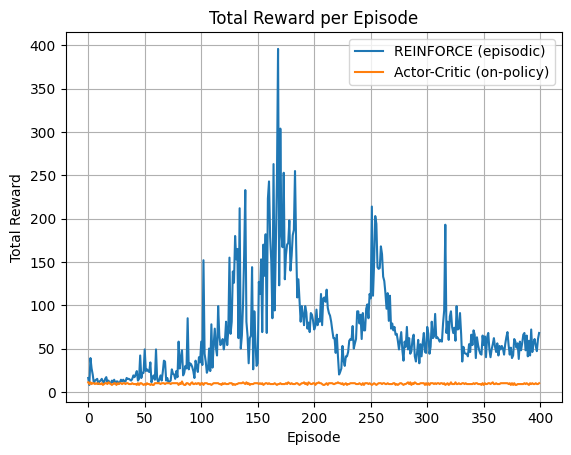

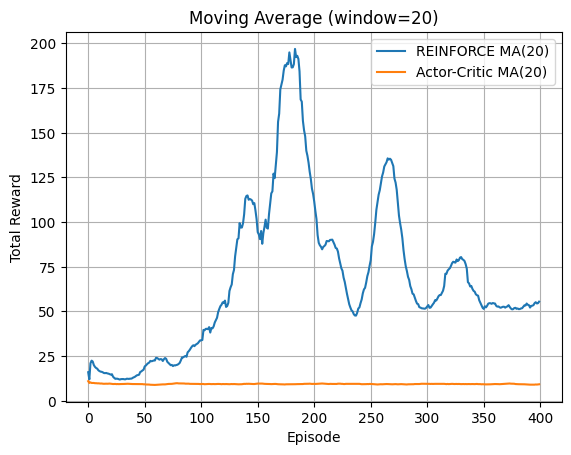

In [ ]:

# Jalankan eksperimen
reinforce_rewards, reinforce_ma, _ = train_reinforce(episodes=400, gamma=0.99, lr=3e-3, seed=123)
a2c_rewards, a2c_ma, _ = train_actor_critic(episodes=400, gamma=0.99, lr_actor=3e-3, lr_critic=3e-3, seed=321)

# Plot hasil
plot_learning_curves(
    [reinforce_rewards, a2c_rewards],
    ["REINFORCE (episodic)", "Actor-Critic (on-policy)"],
    title="Total Reward per Episode"
)

plot_learning_curves(
    [reinforce_ma, a2c_ma],
    ["REINFORCE MA(20)", "Actor-Critic MA(20)"],
    title="Moving Average (window=20)"
)



## 6) Catatan Diskusi & Pertanyaan Reflektif
- Amati perbedaan **stabilitas** antara kurva REINFORCE dan Actor–Critic.
- Coba ubah `hidden`, `lr`, `gamma`, dan `episodes`. Bagaimana pengaruhnya?
- Mengapa normalisasi return di REINFORCE dapat membantu mengurangi varians?
- Apa konsekuensi penggunaan TD target pada Actor–Critic terhadap **bias** dan **varians**?
- Ekstensi opsional: tambahkan **baseline** pada REINFORCE (mengurangkan baseline \(b(s_t)\) dari \(G_t\)).
